<a href="https://colab.research.google.com/github/Waltberry/Hyperparameter-tunning-with-Keras-Tuner-Guided-Project-/blob/main/Hyper_parameter_tunning_with_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing Keras Tuner
!pip install keras-tuner


In [ ]:
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import sklearn.pipeline

In [ ]:
#Downloading the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

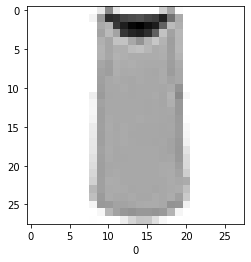

In [ ]:
#Change the index to view various items
plt.imshow(x_train[2],cmap ='binary')
plt.xlabel(y_train[2])
plt.show()

In [ ]:
#Creating the model
def create_model(hp):
  #Hyperparameters
  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
    num_units = hp.Choice('num_units', values=[8, 16, 32])
    dropout_rate = hp.Float('dropout_rate', min_value =0.1, max_value=0.5)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape = (28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for _ in range (0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation="relu"))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']

  )
  return model




In [ ]:
create_model(None).summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 lambda_5 (Lambda)           (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 6280      
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Keras Tuner
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparamters.Int('batch_size', 32, 128, step=32)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs)



In [ ]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mist',
    overwrite= True
  
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [ ]:

tuner.search(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, verbose=False
)

In [ ]:
tuner.results_summary(1)

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, batch_size=128,
    callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))
)